In [1]:
#import libraries
import requests
import pandas as pd
import time
import psycopg2 as ps
from dotenv import load_dotenv
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter
from flair.models import TextClassifier
from flair.data import Sentence

In [2]:
load_dotenv(r"C:\Users\Jon\Projects\.env")

True

In [110]:
#connect to db
def connect_to_db(host_name, dbname, port, username, password):
    try:
        conn = ps.connect(host=host_name, database=dbname, user=username, password=password, port=port)
    except ps.OperationalError as e:
            raise e
    else:
        print('Connected!')
    return conn

In [111]:
host_name = os.getenv('host_name')
dbname = os.getenv('dbname')
port = os.getenv('port')
username = os.getenv('un')
password = os.getenv('password')
conn = None

In [112]:
conn = connect_to_db(host_name, dbname, port, username, password)

Connected!


# 4Ocean Sentiment analysis

Here I'm going be analysing 4Ocean's YouTube data, I absolutely love the goals of what the organization stand for and am interested in seeing how their videos might help further drive public engagement; the more traffic their videos get, the more potential for people to gain interest in their cause.

### Initial investigation

First I want to take a look at how video popularity has changed through time, in order to establish a baseline before diving deeper into sentiment analysis. 

C:\Users\Levin\AppData\Local\Temp\ipykernel_13564\674188949.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


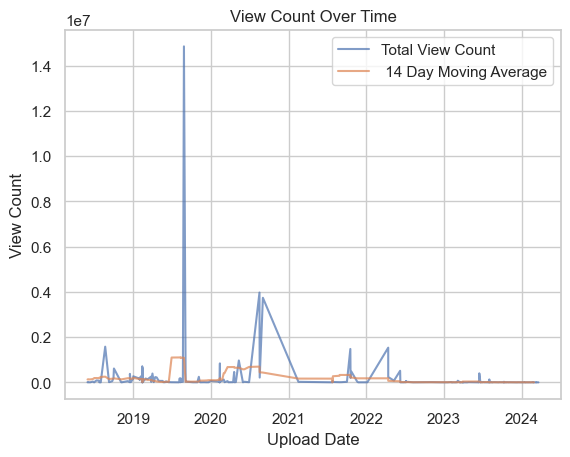

In [115]:
query = """
SELECT * FROM videos;
"""

df = pd.read_sql_query(query, conn)
df.set_index('upload_date', inplace=True)
# Calculate the 14-day moving average for 'view_count' and 'like_count'
df['view_count_14d_ma'] = df['view_count'].rolling(window=14).mean()
df['like_count_14d_ma'] = df['like_count'].rolling(window=14).mean()
df['view_count'].plot(alpha = 0.7)
df['view_count_14d_ma'].plot(alpha = 0.7)
plt.title('View Count Over Time')
plt.xlabel('Upload Date')
plt.ylabel('View Count')
plt.legend(['Total View Count', ' 14 Day Moving Average'])
plt.show()

Seems like videos have become less popular over time with the exception of a few. The major outliers are: The 4ocean Mobile Skimmer (14,848,632 views), 	4ocean Has Officially Pulled 10 Million Pounds (3,969,588 view) and Q	4oce n is now a Certified B Co! (3,738,329 views).  Based on the titles of the videos alone, these are most likely the organizations most monumental moments of their accomplishments. 

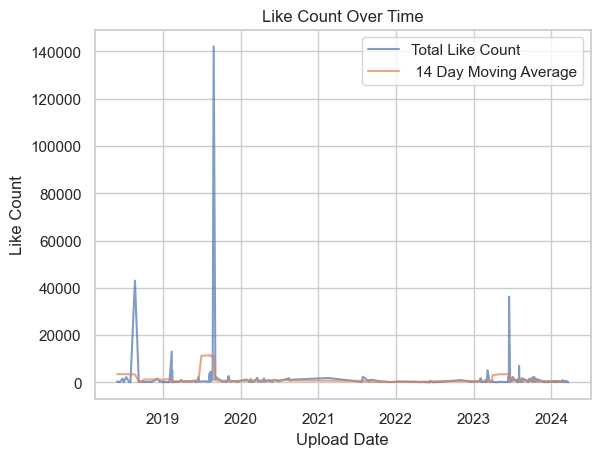

In [116]:
df['like_count'].plot(alpha = 0.7)
df['like_count_14d_ma'].plot(alpha = 0.7)
plt.title('Like Count Over Time')
plt.xlabel('Upload Date')
plt.ylabel('Like Count')
plt.legend(['Total Like Count', ' 14 Day Moving Average'])
plt.show()

Like count over time is somewhat similar to the view count over time, however not all of the top 3 outliers match, only the first video does!
The 4ocean Mobile Skimmer, 	The Mysterious Yellow Bottl, Y	Guatemala Coastline: Before ➡️ After ..

### Sentiment analysis

Next, I'll perform sentiment analysis on the titles using the Flair package to relate title sentiment to video performance. In the following chunk, I run a quick test to make sure the predictions are as I expect, and they are! The negative statement "Flair is bad" is correctly classified as negative, and the positive statement "I really like Flair" is correctly classified as positive

In [12]:
classifier = TextClassifier.load("en-sentiment")
pos_sentence = Sentence("I really like Flair!")
neg_sentence = Sentence("Flair is bad!")
classifier.predict(pos_sentence)
classifier.predict(neg_sentence)
print(pos_sentence.labels, neg_sentence.labels)

['Sentence[5]: "I really like Flair!"'/'POSITIVE' (0.9991)] ['Sentence[4]: "Flair is bad!"'/'NEGATIVE' (0.997)]


In [45]:
def add_sentiment(df):
    title_sentiment = []

    for i,vid in df.iterrows():
        title = Sentence(vid['video_title'])
        classifier.predict(title)
        for label in title.labels:
            if label.score <= .9:
                title_sentiment.append("NEUTRAL")
            else:
                title_sentiment.append(label.value)

    df["title_sentiment"] = title_sentiment

In [46]:
add_sentiment(df)

In [89]:
def summarize_by_sentiment(df):
    # Step 1: Select the columns you need
    df = df.reset_index()
    selected_columns = df[['view_count', 'like_count', 'comment_count', 'title_sentiment']]
    
    # Step 2: Group by 'title_sentiment' and calculate mean for numeric columns
    summary_df = selected_columns.groupby('title_sentiment').agg('mean')
    
    return summary_df

# Apply the function to summarize your DataFrame
summary_df = summarize_by_sentiment(df)
print(summary_df)


                    view_count   like_count  comment_count
title_sentiment                                           
NEGATIVE         105114.057971  1441.492754     157.594203
NEUTRAL           45530.227273  1309.227273      68.060606
POSITIVE         146526.738095  1206.400000      78.061905


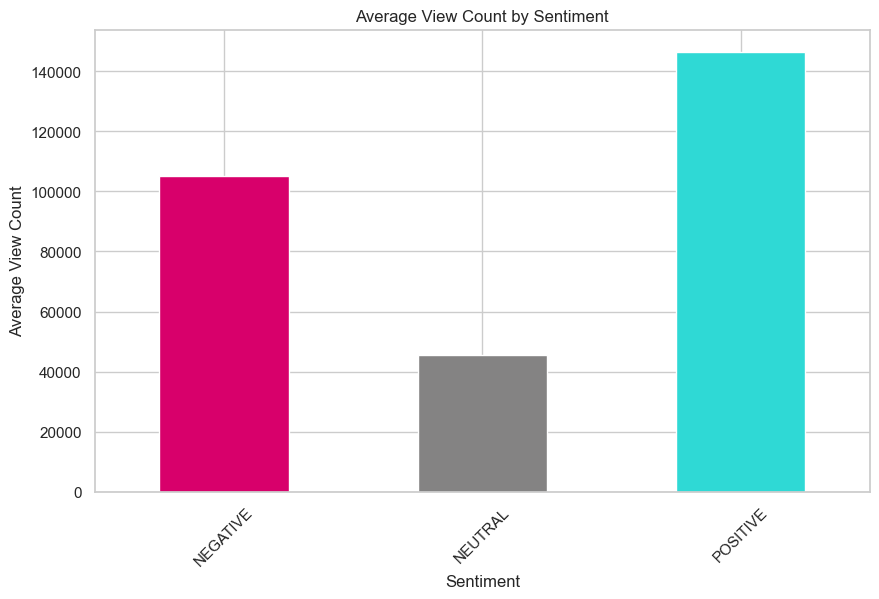

In [98]:
plt.figure(figsize=(10, 6))
summary_df['view_count'].plot(kind='bar', color= {'#d8006b', '#848383', '#2fd9d5'})
plt.title('Average View Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average View Count')
plt.xticks(rotation=45)
plt.show()

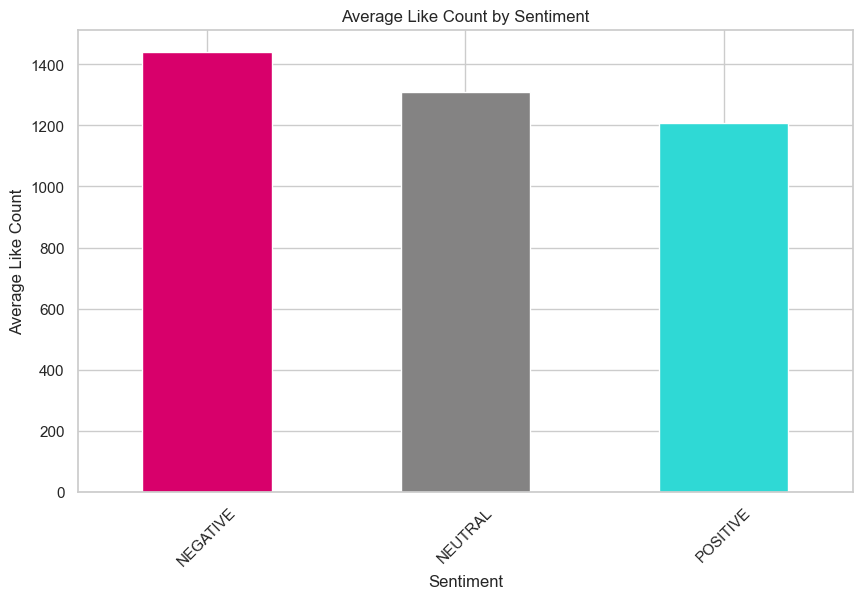

In [100]:
plt.figure(figsize=(10, 6))
summary_df['like_count'].plot(kind='bar', color= {'#d8006b', '#848383', '#2fd9d5'})
plt.title('Average Like Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Like Count')
plt.xticks(rotation=45)
plt.show()

Based on the graph, negative titles have a slightly higher like count on average, though not significantly higher than that of neutral or positive titles.  At a quick glance below looking at negative filtered titles, we'll use the title "One of the Most Polluted Coastlines in the World" as an example.  The title can certainly be considered negative, but it makes sense that videos of such nature would have higher like counts, especially when considering one of the main goals of 4Ocean is to help clean up and remove ocean plastics, we can infer the video gets into detail about how their efforts have made some improvements along this coastline. 

In [108]:
negatives_df = df[df['title_sentiment'] == 'NEGATIVE']

sorted_negatives_df = negatives_df.sort_values(by='comment_count', ascending=False)

sorted_negatives_df

,video_id,video_title,view_count,like_count,dislike_count,comment_count,title_sentiment
upload_date,,,,,,,
2021-02-16,jYXZuo39CpU,4ocean Guess the Weight Challenge!,24646,1863,0,2618,NEGATIVE
2022-06-09,tX4-jy5V2Ak,What if we told you this was what Guatemala’s ...,512275,0,0,2293,NEGATIVE
2023-06-16,uszkdu9IkiY,Guatemala Coastline: Before ➡️ After 🤯 #before...,399187,36273,0,1930,NEGATIVE
2019-02-12,IN9Qg_A5b5U,What happens to the ocean plastic we collect?,304978,13017,0,914,NEGATIVE
2023-03-07,YE-9-K0iaYo,One of the Most Polluted Coastlines in the World,73141,5176,0,508,NEGATIVE
...,...,...,...,...,...,...,...
2023-03-03,GBZKRszC7QI,PSA: Did you know this about styrofoam?,3180,198,0,6,NEGATIVE
2023-06-13,sbkkKJ8wyGc,"Watch out trash, here comes the Pixie Drone! 😎...",2391,152,0,5,NEGATIVE
2023-03-02,0fe7QnQfigk,Less than 10% of all plastic ever produced is ...,2287,190,0,5,NEGATIVE


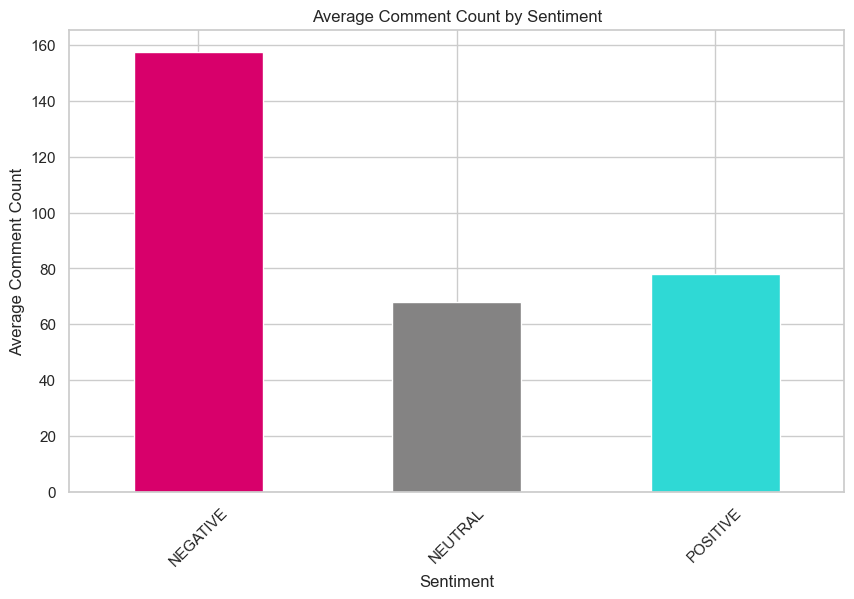

In [101]:
plt.figure(figsize=(10, 6))
summary_df['comment_count'].plot(kind='bar', color= {'#d8006b', '#848383', '#2fd9d5'})
plt.title('Average Comment Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Comment Count')
plt.xticks(rotation=45)
plt.show()

In [106]:
# Filter the DataFrame for rows where the title_sentiment is 'POSITIVE'
positives_df = df[df['title_sentiment'] == 'POSITIVE']

# Sort the filtered DataFrame by view_count in descending order
sorted_positives_df = positives_df.sort_values(by='view_count', ascending=False)

# Display or use the sorted_positives_df as needed

sorted_positives_df

,video_id,video_title,view_count,like_count,dislike_count,comment_count,title_sentiment
upload_date,,,,,,,
2019-08-28,stZcW-b8lT0,The 4ocean Mobile Skimmer,14848632,142143,0,9580,POSITIVE
2020-09-02,sM6oJqk8QBQ,4ocean is now a Certified B Corp!,3738329,1146,0,185,POSITIVE
2022-04-14,7dMBeLS81sw,4ocean Story - Let&#39;s Save Our Oceans,1534253,206,0,34,POSITIVE
2021-10-18,RA4MHmGLNhs,Recovering Tires from the Bottom of the Ocean ...,1476190,431,0,48,POSITIVE
2020-05-12,mwaaamBZqI4,The 4ocean Bracelet is GreenCircle Certified,966804,695,0,119,POSITIVE
...,...,...,...,...,...,...,...
2023-12-20,aNSa0jsy_k4,4ocean x Vision Marine - Leading the Marine Su...,803,108,0,14,POSITIVE
2023-12-11,-pi6eFUu9Zk,Make a Difference in the World Today🤙🌊 #4ocean...,742,133,0,3,POSITIVE
2024-01-22,giyQQdkLZ8Y,Our Most Impactful Bracelet Yet 🤟🏼😁🐠 #coral #c...,707,81,0,6,POSITIVE


In [125]:
sorted_df_by_view_count = df.sort_values(by='view_count', ascending=False).head(5)


In [126]:
sorted_df_by_view_count

,video_id,video_title,view_count,like_count,dislike_count,comment_count,view_count_14d_ma,like_count_14d_ma
upload_date,,,,,,,,
2019-08-28,stZcW-b8lT0,The 4ocean Mobile Skimmer,14848632,142143,0,9580,1.088494e+06,10958.142857
2020-08-17,uBPQqo_8ipM,4ocean Has Officially Pulled 10 Million Pounds!,3969588,1762,0,235,6.959774e+05,963.571429
2020-09-02,sM6oJqk8QBQ,4ocean is now a Certified B Corp!,3738329,1146,0,185,4.336190e+05,833.285714
2018-08-23,3We8hSrR9Eg,The Mysterious Yellow Bottle,1577357,43043,0,1804,2.515620e+05,3397.071429
2022-04-14,7dMBeLS81sw,4ocean Story - Let&#39;s Save Our Oceans,1534253,206,0,34,1.795742e+05,224.000000


In [127]:
sorted_df_by_like_count = df.sort_values(by='like_count', ascending=False).head(5)

In [128]:
sorted_df_by_like_count

,video_id,video_title,view_count,like_count,dislike_count,comment_count,view_count_14d_ma,like_count_14d_ma
upload_date,,,,,,,,
2019-08-28,stZcW-b8lT0,The 4ocean Mobile Skimmer,14848632,142143,0,9580,1.088494e+06,10958.142857
2018-08-23,3We8hSrR9Eg,The Mysterious Yellow Bottle,1577357,43043,0,1804,2.515620e+05,3397.071429
2023-06-16,uszkdu9IkiY,Guatemala Coastline: Before ➡️ After 🤯 #before...,399187,36273,0,1930,3.510507e+04,3459.928571
2019-02-12,IN9Qg_A5b5U,What happens to the ocean plastic we collect?,304978,13017,0,914,1.310858e+05,1473.142857
2023-08-02,bts4C8F-Bhc,"Plastic pollution is a global problem 🌎, but w...",129125,6951,0,211,1.458936e+04,1262.928571
